In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pipeline.utils import read_json, make_folder

# EXP 3: Comparing MultiCC and SingleCC to multi-model under various degrees of errors

## Read results from disc

In [45]:
# datasets = ['adult', 'german', 'compas', 'cardio', 'bank', 'meps16', 'lawgpa', 'credit', 'UFRGS']
# y_cols = ['Income Binary', 'credit', 'two_year_recid'] + ['Y' for i in range(6)]
# sensi_cols = ['sex', 'age', 'race'] + ['C0' for i in range(6)]

datasets = ['lawgpa']
y_cols = ['Y']
sensi_cols = ['C0']


seeds = [1, 12345, 6, 2211, 15]
# , 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 0xdeadcafe, 0xdeadbeef, 0xbeefcafe]

In [46]:
# extracting results from MultiCC and multi-model over errorneous data
exp_setting = 'Multi_eval'

# datasets = ['lawgpa', 'meps16']
errors_k = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

res_path = 'intermediate/models/'
group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff']
settings = ['A', 'E', 'F']

eval_path = 'intermediate/evals/'

eval_file = exp_setting+'_errors_data'+str(len(datasets))+'_n'+str(len(seeds))+'.csv'


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    multi_df = pd.DataFrame(columns=['data', 'seed', 'error', 'setting', 'group', 'metric', 'value'])
    for error_i in errors_k: 
        exp_suffix = 'error{:.2f}'.format(error_i)
        for data_name in datasets:
            for seed in seeds:
                eval_res = read_json(res_path+data_name+'/'+'-'.join([exp_setting, str(seed), exp_suffix]))
                for setting in settings:
                    for group in ['all', 'G0', 'G1']:
                        base = [data_name, seed, error_i, setting, group]
                        for metric_i in group_eval_metrics:
                            multi_df.loc[multi_df.shape[0]] = base + [metric_i, eval_res[setting][group][metric_i]]
                    for metric_i in overall_metrics:
                        multi_df.loc[multi_df.shape[0]] = [data_name, seed, error_i, setting, 'all'] + [metric_i, eval_res[setting]['all'][metric_i]]

    multi_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    multi_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    

Save evaluation results at intermediate/evals/Multi_eval_errors_data1_n5.csv


In [47]:
multi_df.head()

,data,seed,error,setting,group,metric,value
0,lawgpa,1,0.05,A,all,AUC,0.617000
1,lawgpa,1,0.05,A,all,ACC,0.622000
2,lawgpa,1,0.05,A,all,SR,0.576969
3,lawgpa,1,0.05,A,all,BalAcc,0.617024
4,lawgpa,1,0.05,A,G0,AUC,0.500000


In [48]:
# extracting results from MultiCC and multi-model over errorneous data
exp_setting = 'Single_eval'

# datasets = ['lawgpa', 'meps16']
errors_k = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

res_path = 'intermediate/models/'
group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff']
settings = ['C']

eval_path = 'intermediate/evals/'

eval_file = exp_setting+'_SingleCC_errors_data'+str(len(datasets))+'_n'+str(len(seeds))+'.csv'


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    single_df = pd.DataFrame(columns=['data', 'seed', 'error', 'setting', 'group', 'metric', 'value'])
    for error_i in errors_k: 
        exp_suffix = 'error{:.2f}'.format(error_i)
        for data_name in datasets:
            for seed in seeds:
                eval_res = read_json(res_path+data_name+'/'+'-'.join([exp_setting, str(seed), 'SingleCC', exp_suffix]))
                for setting in settings:
                    for group in ['all', 'G0', 'G1']:
                        base = [data_name, seed, error_i, setting, group]
                        for metric_i in group_eval_metrics:
                            single_df.loc[single_df.shape[0]] = base + [metric_i, eval_res[setting][group][metric_i]]
                    for metric_i in overall_metrics:
                        single_df.loc[single_df.shape[0]] = [data_name, seed, error_i, setting, 'all'] + [metric_i, eval_res[setting]['all'][metric_i]]

    single_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    single_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    

Read evaluation results from intermediate/evals/Single_eval_SingleCC_errors_data1_n5.csv


In [49]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        if x.iloc[1] < 0: 
            return 0
        else: # G0 has better outcome
            return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [50]:
multi_df['norm_value'] = multi_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
multi_df['norm_flag'] = multi_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

multi_df['setting'] = multi_df['setting'].replace({'A': 'no intervention', 'E': 'multi-model', 'F': 'MultiCC'})
multi_df.head()

,data,seed,error,setting,group,metric,value,norm_value,norm_flag
0,lawgpa,1,0.05,no intervention,all,AUC,0.617000,0.617000,0
1,lawgpa,1,0.05,no intervention,all,ACC,0.622000,0.622000,0
2,lawgpa,1,0.05,no intervention,all,SR,0.576969,0.576969,0
3,lawgpa,1,0.05,no intervention,all,BalAcc,0.617024,0.617024,0
4,lawgpa,1,0.05,no intervention,G0,AUC,0.500000,0.500000,0


In [51]:
single_df['norm_value'] = single_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
single_df['norm_flag'] = single_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

single_df['setting'] = single_df['setting'].replace({'C': 'SingleCC'})
single_df.head()

,data,seed,error,setting,group,metric,value,norm_value,norm_flag
0,lawgpa,1,0.05,SingleCC,all,AUC,0.579000,0.579000,0
1,lawgpa,1,0.05,SingleCC,all,ACC,0.587000,0.587000,0
2,lawgpa,1,0.05,SingleCC,all,SR,0.626790,0.626790,0
3,lawgpa,1,0.05,SingleCC,all,BalAcc,0.578553,0.578553,0
4,lawgpa,1,0.05,SingleCC,G0,AUC,0.590000,0.590000,0


In [52]:
eval_df = pd.concat([multi_df, single_df])
eval_df.head()

,data,seed,error,setting,group,metric,value,norm_value,norm_flag
0,lawgpa,1,0.05,no intervention,all,AUC,0.617000,0.617000,0
1,lawgpa,1,0.05,no intervention,all,ACC,0.622000,0.622000,0
2,lawgpa,1,0.05,no intervention,all,SR,0.576969,0.576969,0
3,lawgpa,1,0.05,no intervention,all,BalAcc,0.617024,0.617024,0
4,lawgpa,1,0.05,no intervention,G0,AUC,0.500000,0.500000,0


## Draw scatter plot

In [58]:
def scatter_plots(df, vis_dataset, vis_metric, vis_settings, 
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#fffacd', '#3cb371', '#20603d'], bg_color = '#f3f3f3', marks=['^', 's', 'o'],
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=3, save_to_disc=False, 
              plot_path = 'intermediate/evals/plots/'):

    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    
    vis_df = input_df[(input_df['data']==vis_dataset) & (input_df['metric']==vis_metric) & (input_df['group']=='all')]
    
    for setting_i, color_i, mark_i in zip(vis_settings, colors, marks):
        for x_i in x_ticks:
            x_df = vis_df[(vis_df['setting']==setting_i) & (vis_df['error']==x_i)]
            y_values = np.array(x_df['norm_value'])
            n_reverse = sum(np.array(x_df['norm_flag']))
            if n_reverse > int(len(y_values) * 0.7): # majoirty of cases in which G0 has better outcomes
                edge_color = 'red'
            else:
                edge_color = 'black'
            ax.scatter(x_i, np.mean(y_values), color=color_i, marker=mark_i, edgecolors=edge_color, s=95)
            print(setting_i, x_i, round(np.mean(y_values), 3))
    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    for setting_i, color_i, mark_i, legend_i in zip(vis_settings, colors, marks, legends):
        ax.scatter(-2, -1, color=color_i, marker=mark_i, s=85, edgecolors='black', label=legend_i)
 
    
    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    
    plt.xlim([0.09, max(x_ticks)+0.01])
    plt.xticks(x_ticks, fontsize=font_label)
    
    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(plot_path+vis_dataset+'_'+vis_metric+'.pdf', bbox_inches="tight")
        print('Scatter plot is saved at ', plot_path+vis_dataset+'_'+vis_metric+'.pdf')

multi-model 0.05 0.585
multi-model 0.1 0.585
multi-model 0.15 0.585
multi-model 0.2 0.585
multi-model 0.25 0.585
multi-model 0.3 0.585
MultiCC 0.05 0.571
MultiCC 0.1 0.57
MultiCC 0.15 0.571
MultiCC 0.2 0.57
MultiCC 0.25 0.569
MultiCC 0.3 0.57
SingleCC 0.05 0.592
SingleCC 0.1 0.601
SingleCC 0.15 0.597
SingleCC 0.2 0.591
SingleCC 0.25 0.594
SingleCC 0.3 0.6


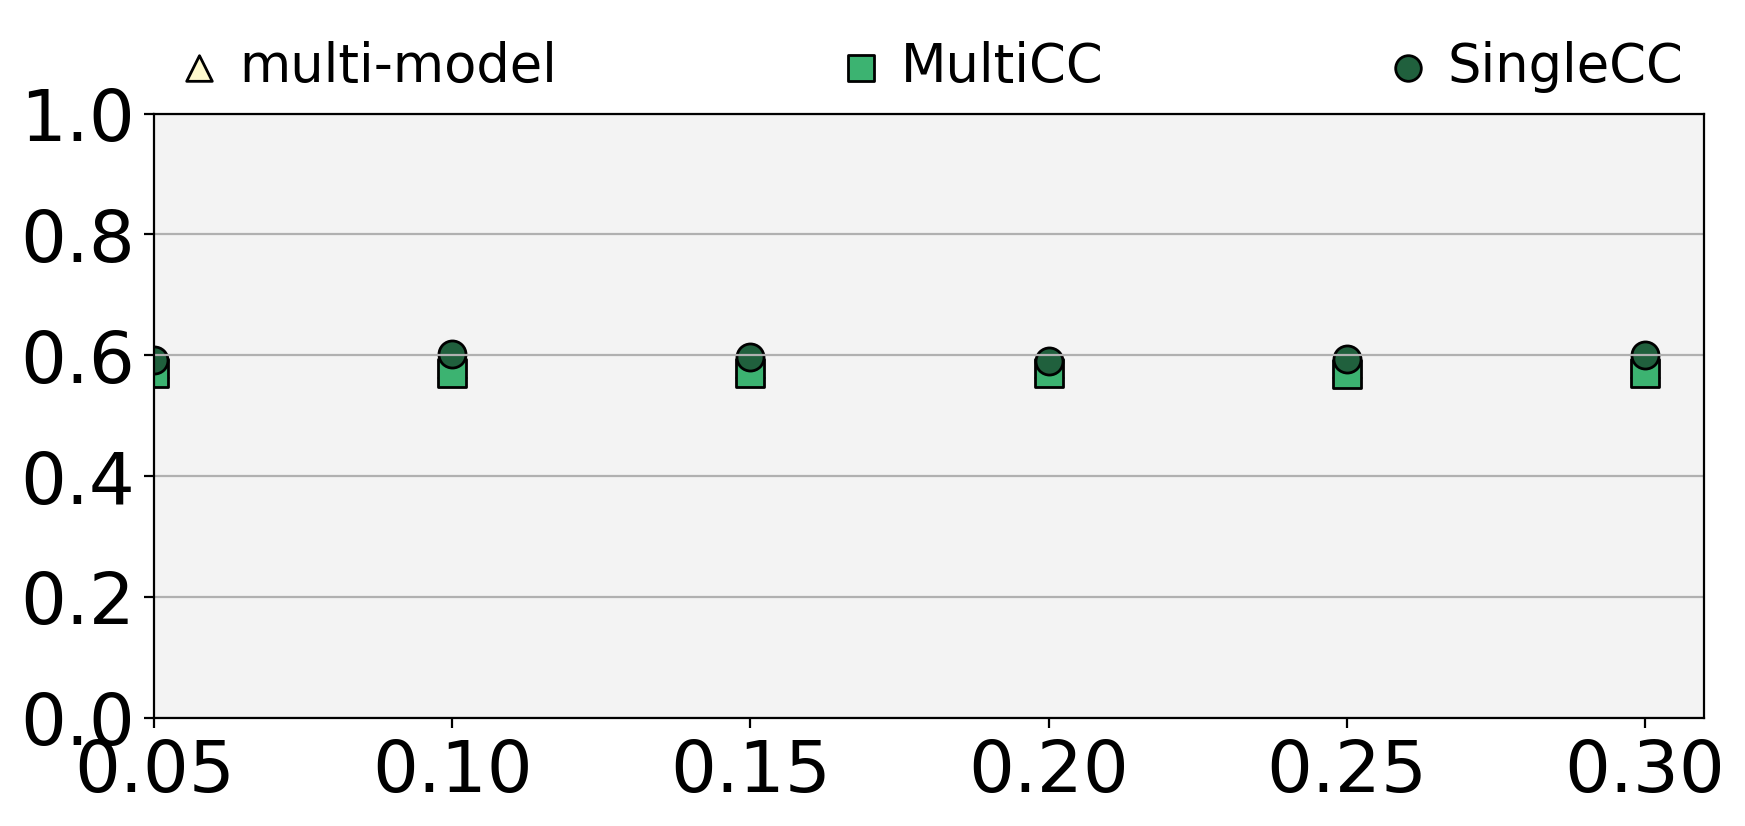

In [59]:
plot_path = 'intermediate/evals/plots/'
exp_name = 'exp3'
# initiate a new folder for the plots
exp_path = plot_path+exp_name+'/'
make_folder(exp_path)



exp_settings = ['multi-model', 'MultiCC', 'SingleCC']

exp_name = 'lawgpa' # 'lawgpa'
exp_ticks = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

exp_metric = 'BalAcc'
scatter_plots(eval_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


multi-model 0.05 0.436
multi-model 0.1 0.368
multi-model 0.15 0.331
multi-model 0.2 0.329
multi-model 0.25 0.336
multi-model 0.3 0.335
MultiCC 0.05 0.426
MultiCC 0.1 0.545
MultiCC 0.15 0.652
MultiCC 0.2 0.748
MultiCC 0.25 0.823
MultiCC 0.3 0.847
SingleCC 0.05 0.456
SingleCC 0.1 0.276
SingleCC 0.15 0.331
SingleCC 0.2 0.459
SingleCC 0.25 0.441
SingleCC 0.3 0.334


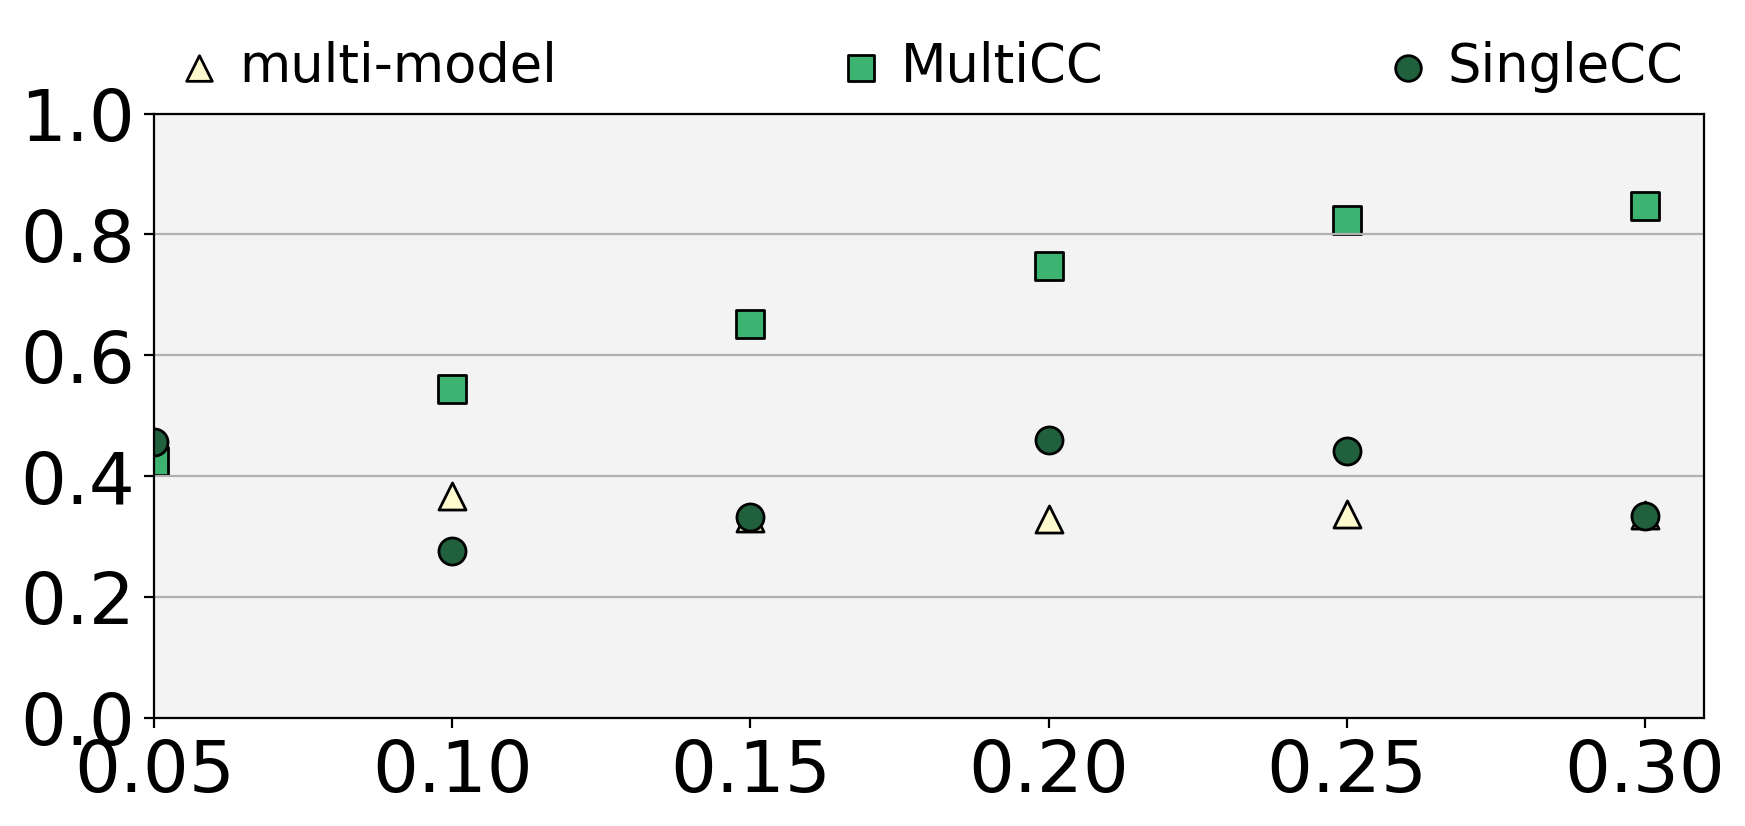

In [60]:
exp_metric = 'DI'
scatter_plots(eval_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


multi-model 0.05 0.717
multi-model 0.1 0.677
multi-model 0.15 0.657
multi-model 0.2 0.655
multi-model 0.25 0.657
multi-model 0.3 0.65
MultiCC 0.05 0.503
MultiCC 0.1 0.61
MultiCC 0.15 0.707
MultiCC 0.2 0.792
MultiCC 0.25 0.86
MultiCC 0.3 0.878
SingleCC 0.05 0.723
SingleCC 0.1 0.586
SingleCC 0.15 0.629
SingleCC 0.2 0.735
SingleCC 0.25 0.723
SingleCC 0.3 0.64


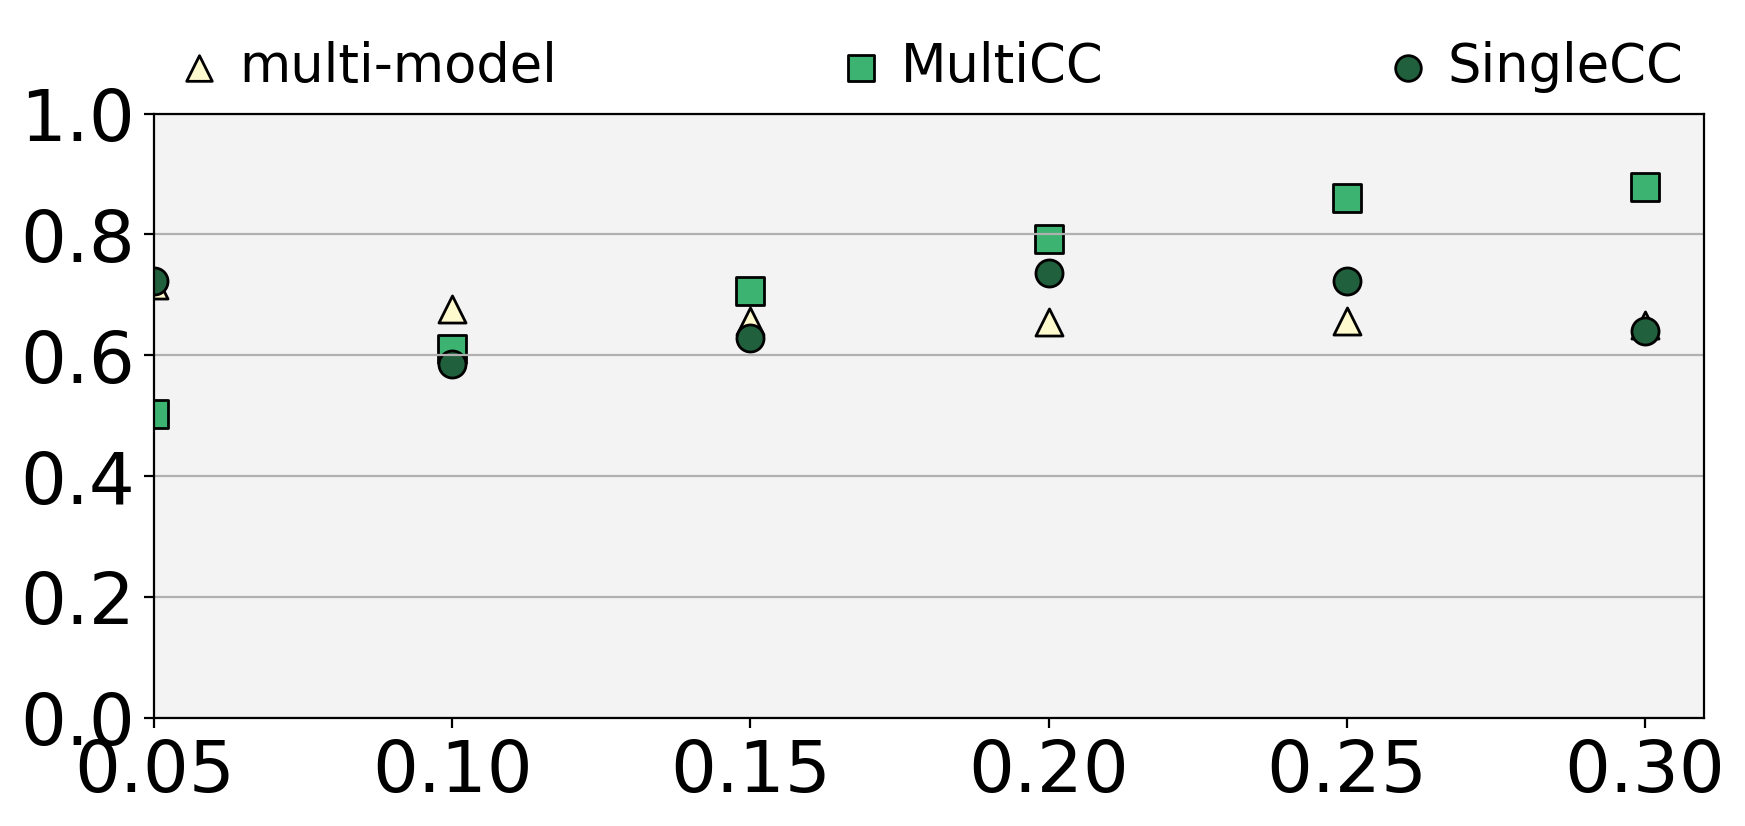

In [61]:
exp_metric = 'SPDiff'
scatter_plots(eval_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


multi-model 0.05 0.64
multi-model 0.1 0.63
multi-model 0.15 0.63
multi-model 0.2 0.643
multi-model 0.25 0.659
multi-model 0.3 0.659
MultiCC 0.05 0.597
MultiCC 0.1 0.663
MultiCC 0.15 0.727
MultiCC 0.2 0.797
MultiCC 0.25 0.864
MultiCC 0.3 0.882
SingleCC 0.05 0.747
SingleCC 0.1 0.626
SingleCC 0.15 0.675
SingleCC 0.2 0.787
SingleCC 0.25 0.775
SingleCC 0.3 0.697


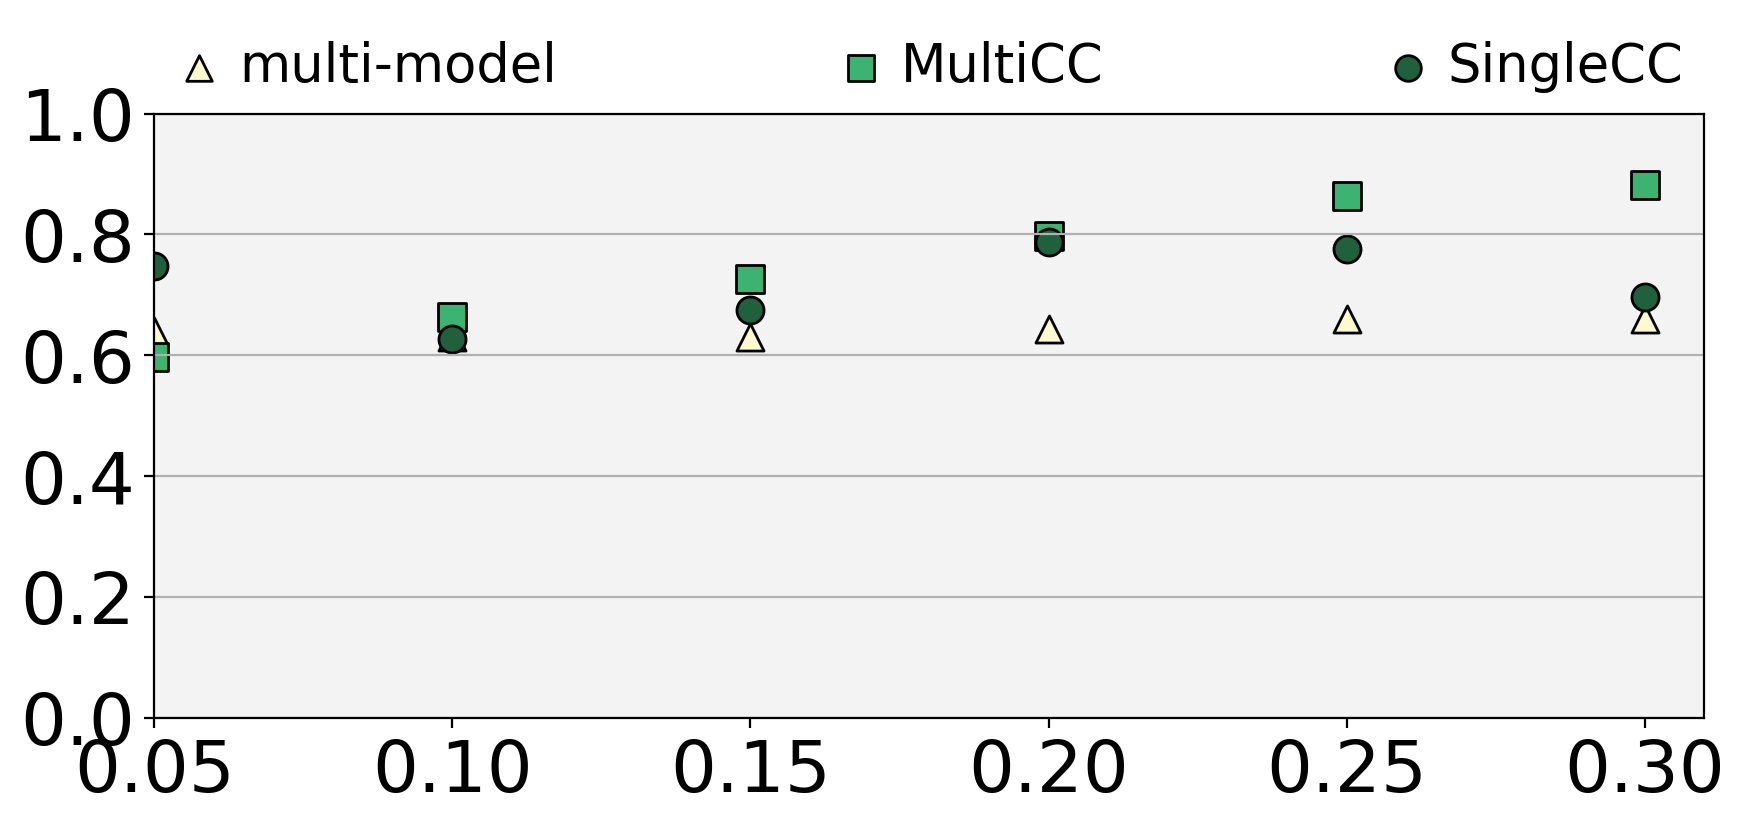

In [62]:
exp_metric = 'AvgOddsDiff'
scatter_plots(eval_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)
